Using device: cuda (Mode: Manual Fixed-Color Test)
Training on Random Jitter...
Step 0: Loss 3417.59
Step 200: Loss 400.80
Visualizing with FIXED Hard Cases...


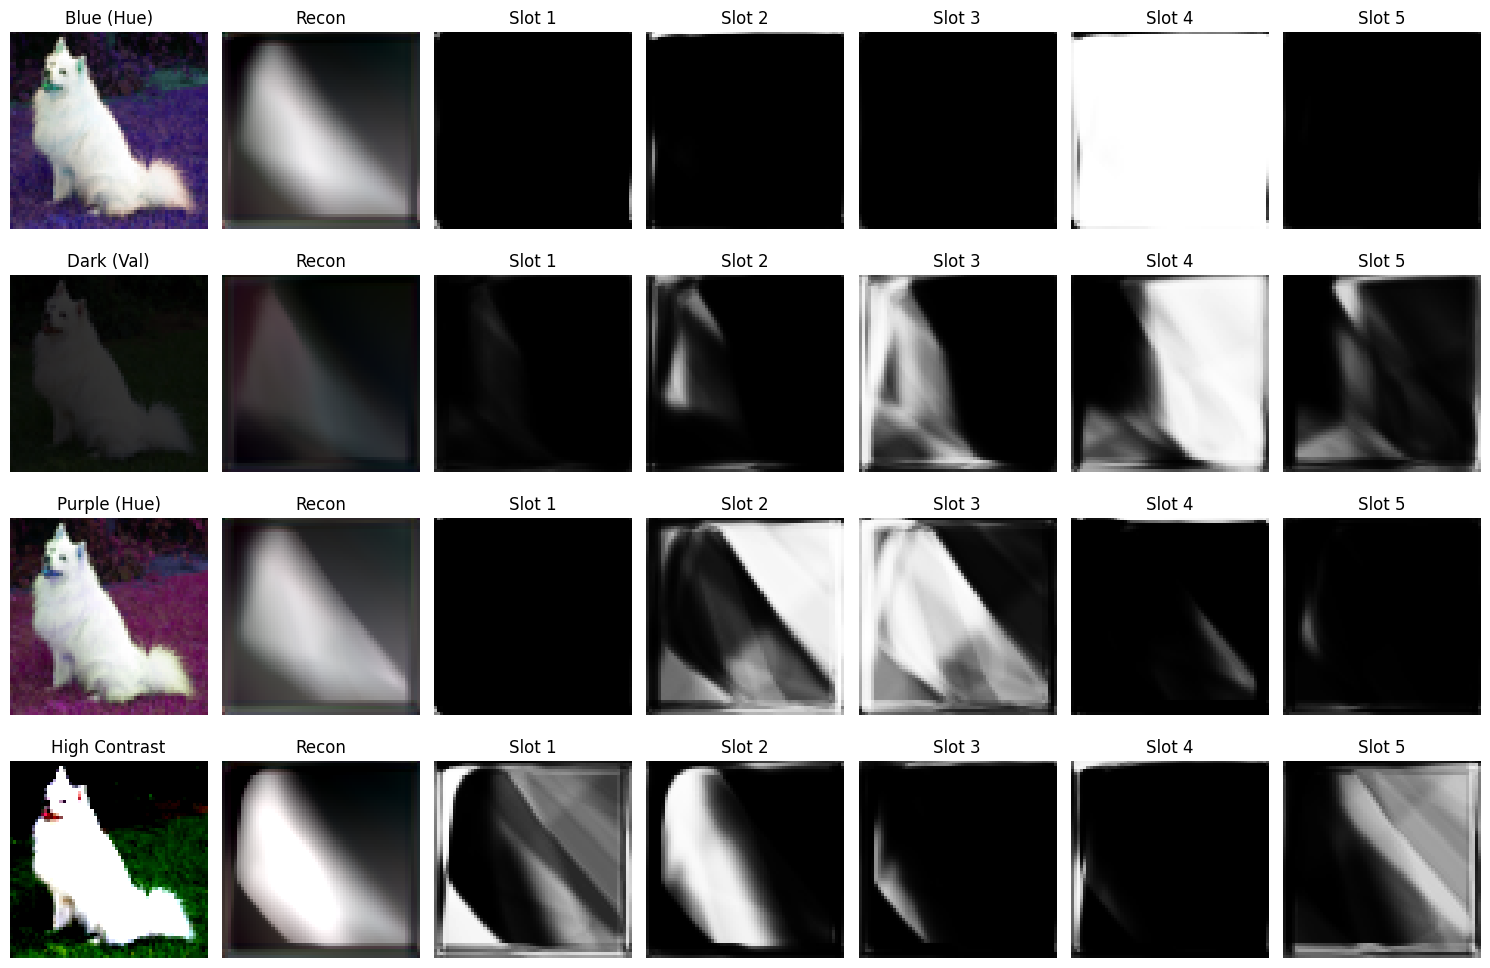

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF # 追加
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ==========================================
# 1. データセット (学習用はランダム激変のまま)
# ==========================================
class JitterDogDataset(Dataset):
    def __init__(self, resolution=(64, 64), length=10000):
        self.resolution = resolution
        self.length = length
        self.raw_img = self._load_dog_image()
        
        # 学習用: ランダムに激しく変える
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.5),
            transforms.ToTensor()
        ])

    def _load_dog_image(self):
        url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            return img.resize(self.resolution)
        except:
            print("Using noise (No Internet).")
            return Image.fromarray(np.uint8(np.random.rand(*self.resolution, 3)*255))

    def __getitem__(self, idx):
        return self.transform(self.raw_img)

    def __len__(self):
        return self.length

# ==========================================
# 2. Slot Attention & Model (5ch入力)
# ==========================================
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, hidden_dim=64):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(inplace=True), nn.Linear(hidden_dim, dim)
        )

    def forward(self, inputs, current_temp, num_slots=None):
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        inputs = self.norm_input(inputs)
        slots = torch.randn(b, n_s, d, device=inputs.device)
        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = (dots / current_temp).softmax(dim=1) + 1e-8
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
        return slots

class SlotModel(nn.Module):
    def __init__(self, resolution=(64, 64), num_slots=5, hidden_dim=32):
        super().__init__()
        self.resolution = resolution
        self.num_slots = num_slots
        self.hidden_dim = hidden_dim
        
        # RGB(3) + Grid(2) = 5ch
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 5, padding=2), nn.ReLU(), 
        )
        self.pos_emb = nn.Parameter(torch.randn(1, hidden_dim, resolution[0], resolution[1]) * 0.01)
        self.slot_attention = SlotAttention(num_slots, hidden_dim, iters=5, hidden_dim=64)
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim + 2, 32, 5, padding=2), nn.ReLU(), 
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 4, 3, padding=1),
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return grid

    def forward(self, x, current_temp):
        b, c, h, w = x.shape
        grid = self.build_grid(b, (h, w), x.device)
        x_with_grid = torch.cat([x, grid], dim=1)
        
        x_enc = self.encoder(x_with_grid) + self.pos_emb
        x_flat = x_enc.permute(0, 2, 3, 1).reshape(b, -1, self.hidden_dim)
        
        slots = self.slot_attention(x_flat, current_temp)
        
        slots_img = slots.view(b * self.num_slots, self.hidden_dim, 1, 1).repeat(1, 1, h, w)
        grid_flat = self.build_grid(b * self.num_slots, (h, w), x.device)
        out = self.decoder(torch.cat([slots_img, grid_flat], dim=1))
        out = out.view(b, self.num_slots, 4, h, w)
        
        recons = out[:, :, :3, :, :]
        masks = torch.softmax(out[:, :, 3:4, :, :] / current_temp, dim=1)
        recon_combined = torch.sum(recons * masks, dim=1)
        return recon_combined, recons, masks

# ==========================================
# 3. 実行: 手動固定による厳密比較
# ==========================================
def run_fair_comparison():
    torch.manual_seed(42) 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device} (Mode: Manual Fixed-Color Test)")

    dataset = JitterDogDataset(length=10000)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

    model = SlotModel(resolution=(64, 64), num_slots=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0004)

    print("Training on Random Jitter...")
    model.train()
    
    total_steps = 1000
    start_temp = 1.0
    end_temp = 0.01

    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        progress = min(1.0, i / total_steps)
        current_temp = start_temp * (1 - progress) + end_temp * progress
        
        optimizer.zero_grad()
        recon, _, masks = model(batch, current_temp)
        loss = ((batch - recon)**2).sum()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Loss {loss.item()/32:.2f}") 
        if i >= total_steps:
            break

    # ==========================================
    # 結果確認: 乱数を使わず手動で作る
    # ==========================================
    print("Visualizing with FIXED Hard Cases...")
    model.eval()
    
    raw_img = dataset.raw_img # PIL Image
    
    # 手動で「あの色」を作る
    # 1. 青い犬 (色相をガッツリ回す)
    img1 = TF.adjust_hue(raw_img, 0.45) 
    img1 = TF.adjust_saturation(img1, 1.5) # 色を濃く
    
    # 2. 暗黒の犬 (明度を下げる)
    img2 = TF.adjust_brightness(raw_img, 0.2)
    
    # 3. 紫/ピンクの犬 (色相逆回転)
    img3 = TF.adjust_hue(raw_img, -0.4)
    img3 = TF.adjust_saturation(img3, 1.5)
    
    # 4. ギラギラした犬 (コントラスト強調)
    img4 = TF.adjust_contrast(raw_img, 3.0)
    
    # Tensor化してバッチにする
    test_batch = torch.stack([
        transforms.ToTensor()(img1),
        transforms.ToTensor()(img2),
        transforms.ToTensor()(img3),
        transforms.ToTensor()(img4)
    ]).to(device)

    with torch.no_grad():
        recon, _, masks = model(test_batch, current_temp=0.01)

    def to_np(t): return t.permute(1, 2, 0).cpu().numpy().clip(0, 1)
    def mask_to_np(m): return m[:, 0].cpu().numpy()

    fig, axes = plt.subplots(4, 7, figsize=(15, 10))
    titles = ["Blue (Hue)", "Dark (Val)", "Purple (Hue)", "High Contrast"]
    
    for row in range(4):
        # Input
        axes[row, 0].imshow(to_np(test_batch[row]))
        axes[row, 0].set_title(titles[row])
        axes[row, 0].axis('off')
        
        # Recon
        axes[row, 1].imshow(to_np(recon[row]))
        axes[row, 1].set_title("Recon")
        axes[row, 1].axis('off')
        
        # Masks
        m_np = mask_to_np(masks[row])
        for k in range(5):
            axes[row, k+2].imshow(m_np[k], cmap='gray', vmin=0, vmax=1)
            axes[row, k+2].set_title(f"Slot {k+1}")
            axes[row, k+2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_fair_comparison()